# **Project: Amazon Product Recommendation System**

## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
# Installing surprise library
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross validation
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# Define column names
column_names = ['user_id', 'prod_id', 'rating', 'timestamp']
# import data
df_original = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DSFoundations/Project/Project 3 Recommendation Systems/ratings_Electronics.csv",
                          header=None, names=column_names)
df_original.head()# data preview

# Drop the 'timestamp' column from df_original and create a new DataFrame df
df = df_original.drop(columns=['timestamp'])

df.head()


,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [ ]:
#Dataframe summary.
print(f"The data has {df.shape[0]} observations and {df.shape[1]} variables.\n ")
df.info()
df.describe(include='all').T

The data has 7824482 observations and 3 variables.
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,7824482,4201696,A5JLAU2ARJ0BO,520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prod_id,7824482,476002,B0074BW614,18244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,7824482.0,NaN,NaN,NaN,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

print(f"{len(remove_users)} of {len(df_original.user_id.unique())} users removed.") #how many users are being removed

4200156 of 4201696 users removed.


In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_prod = []

for prod, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_prod.append(prod)

df_final = df.loc[~ df.prod_id.isin(remove_prod)]

print(f"{len(remove_prod)} of {len(df.prod_id.unique())} remaining products removed.") #how many product are being removed from the dataset

42501 of 48190 remaining products removed.


In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
#Data shape.
print(f"There are {df_final.shape[0]} rows and {df_final.shape[1]} columns in the dataset.")
print(f'There are {df_final.duplicated().sum()} total duplicate rows.' ) #checking for duplicates.
print("--" *50,'\n')

#Random sample of 5 observations
print('Sample of dataframe.')
df_final.sample(5)

There are 65290 rows and 3 columns in the dataset.
There are 0 total duplicate rows.
---------------------------------------------------------------------------------------------------- 

Sample of dataframe.


,user_id,prod_id,rating
7123224,A1P0JSFW184ZXJ,B00BJOUFY2,5.0
2197136,A2WLNSZ9U0T1S3,B001OI2YNS,4.0
3969693,A1F0KPA232MTYC,B0049SCB2Y,5.0
4285442,A1IG1I6MR3HAWA,B004N6259G,5.0
3666415,AYNAH993VDECT,B003XU6H8I,5.0


**Observations**
* The data has been paired down to 65290 observations of users with at least 50 interactions and products with at least 5 ratings.
* No duplicate observations - meaning no user interacted with a product more than once.

### **Data types**

In [ ]:
#Data Info
print(f'Variables names, none missing count, and their data type:\n')
print(df_final.info())
print("--" *50,'\n')

Variables names, none missing count, and their data type:

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB
None
---------------------------------------------------------------------------------------------------- 



**Observations**
* User id's and product id's are object and rating is float.

### **Checking for missing values**

In [ ]:
# Check for missing values present
print(df_final.isna().sum())
print()
#Checking for placeholder values
df_final.rating.value_counts()

user_id    0
prod_id    0
rating     0
dtype: int64



rating
5.0    36315
4.0    18127
3.0     6481
2.0     2515
1.0     1852
Name: count, dtype: int64

**Observations**
* There are no missing values in the data set.
* All ratings are between 1-5 as expected.

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations

df_final.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,65290,1540,ADLVFFE4VBT8,295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prod_id,65290,5689,B0088CJT4U,206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,65290.0,NaN,NaN,NaN,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Observations**
* Mean rating is 4.3 with 75% of the ratings being 4 or higher.
* 1540 unique users remain, one appearing 295 times.
* 5689 unique products remain, most popular appearing 206 times.
* Each user and product are a small proportion of the total observations

### **Checking the rating distribution**

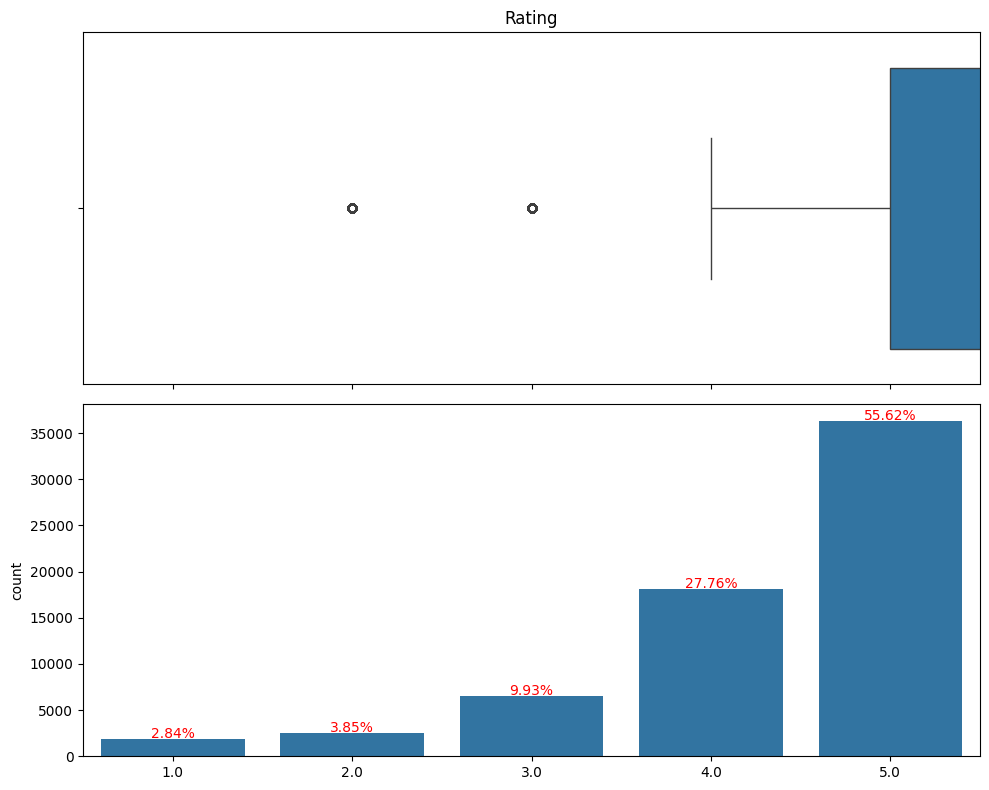

In [ ]:
# Histogram and Countplot
# Create a figure and axes for subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Boxplot
sns.boxplot(data=df_final, x='rating', ax=axes[0])
axes[0].set_title('Rating')

# Count plot
g1 = sns.countplot(data=df_final, x='rating', ax=axes[1])
g1.set_xlabel('')

# Calculate percentage of each category for count plot
total = float(len(df_final))
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width() / 2.,
            height + 150,
            '{:.2f}%'.format((height / total) * 100),
            ha="center", color='red')


plt.tight_layout()

plt.show()


**Observations**
* Over half of the ratings are 5 stars.
* Less than 8% of the ratings are under 3 stars.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
print(f'Total number of observations remaining: {df_final.shape[0]}.')
print(f'Total number of users remaining: {df_final.user_id.nunique()}.')
print(f'Total number of products remaining: {df_final.prod_id.nunique()}.')
print("--" *50,'\n')
###
object_columns = df_final.columns[df_final.dtypes=='object']

#printing a percent of each unique value by column.
print('Percent of each Unique Value')
for col in object_columns:
  ccount = df_final[col].value_counts(normalize=True,dropna=False)
  print(ccount)
  print()
print("--" *50,'\n')

Total number of observations remaining: 65290.
Total number of users remaining: 1540.
Total number of products remaining: 5689.
---------------------------------------------------------------------------------------------------- 

Percent of each Unique Value
user_id
ADLVFFE4VBT8      0.004518
A3OXHLG6DIBRW8    0.003523
A1ODOGXEYECQQ8    0.003324
A36K2N527TXXJN    0.003247
A25C2M3QF9G7OQ    0.003109
                    ...   
A16CVJUQOB6GIB    0.000031
A2BGZ52M908MJY    0.000031
A3DL29NLZ7SXXG    0.000015
AP2NZAALUQKF5     0.000015
A3MV1KKHX51FYT    0.000015
Name: proportion, Length: 1540, dtype: float64

prod_id
B0088CJT4U    0.003155
B003ES5ZUU    0.002818
B000N99BBC    0.002558
B007WTAJTO    0.002512
B00829TIEK    0.002282
                ...   
B00368CDH6    0.000077
B0036AZA6A    0.000077
B0036E8V08    0.000077
B0036QL1JY    0.000077
B00LGQ6HL8    0.000077
Name: proportion, Length: 5689, dtype: float64

------------------------------------------------------------------------------

**Observations**
* Proportion of users to total observations is approximately 2.36%. Good indication of engagement for remaining users.
* Proportion of products to total observations is roughly 8.70%. Good variety of products.
* The top user proportion vs. lowest user proportion is not an extreme difference. It is similar for products.
* No subset of users or products should dominate a RSS.

Overall, the proportions of users and products to total observations indicate that the dataset is suitable for building a recommendation system and can provide valuable insights into user preferences.

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
top = df_final.user_id.value_counts()
top.head(10)

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64

**Observation**
* No dramatic change in number of ratings over the top 10. This further supports no subset will dominate our system.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
product_average = df_final.groupby('prod_id')['rating'].mean()
# Calculate the count of ratings for each product
product_count = df_final.groupby(['prod_id']).count()['rating']
# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'average':product_average, 'rating_count':product_count})
# Sort the dataframe by average of ratings in the descending order
final_rating.sort_values('average', ascending=False, inplace=True)

# See the first five records of the "final_rating" dataset
final_rating.head(5)

,average,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_rated(data, n=10, min_ratings = 10):
  recs = data[data['rating_count']>min_ratings] #filtering out values below threshold
  recs = recs.sort_values('average', ascending=False) #sorting values in descending order by average.
  return list(recs.head(n).index)



### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
top_rated(final_rating, n=5, min_ratings=50)

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
top_rated(final_rating, n=5, min_ratings=100)

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(test)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final, reader)

# Splitting the data into train and test datasets
train, test = train_test_split(data, test_size=0.3, random_state=53)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Fit the model on the training data
user_mod = algo_knn_user.fit(train)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(user_mod, k=10, threshold=3.5)

RMSE: 1.0360
Precision:  0.859
Recall:  0.788
F_1 score:  0.822


**Observations**
* Slightly better precision than recall.
* A strong precision is likely more desirable because having relavent recommendations is more important than making sure all relavant products are recommended.  
* Model performs well overall with all three metrics performing strongly.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
pred= user_mod.predict(uid= 'A3LDPF5FMB782Z',
                       iid='1400501466',
                       r_ui=5
                       )
print(f'This user has a predicted rating of {pred.est} with an actual rating of {pred.r_ui}')


This user has a predicted rating of 2.5 with an actual rating of 5


**Observations**
* This users predicted rating for a product that has already been rated is significantly lower than actual.
* This is an example of a false negative which impacts recall.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
df_final.loc[df_final.prod_id!='1400501466']['user_id']

2082       A2ZR3YTMEEIIZ4
2150       A3CLWR1UUZT6TG
2162        A5JLAU2ARJ0BO
2228       A1P4XD7IORSEFN
2363       A341HCMGNZCBIT
                ...      
7824423    A34BZM6S9L7QI4
7824424    A1G650TTTHEAL5
7824425    A25C2M3QF9G7OQ
7824426     A1E1LEVQ9VQNK
7824427    A2NYK9KWFMJV4Y
Name: user_id, Length: 65284, dtype: object

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
pred= user_mod.predict(uid= 'A34BZM6S9L7QI4',
                       iid='1400501466'
                       )
print(f'This user has a predicted rating of {round(pred.est,3)} with an actual rating of {pred.r_ui}')


This user has a predicted rating of 3.0 with an actual rating of None


**Observations**
* The predicted rating for this product to this user is 3.
* This product has very few interactions.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine','pearson','pearson_baseline'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.97065202400556
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_algo_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6, verbose=False)

# Training the algorithm on the trainset
user_mod_tuned = sim_algo_optimized.fit(train)

# Let us compute precision@k and recall@k also with k =10
print('Tuned Model\n')
precision_recall_at_k(user_mod_tuned, k= 10, threshold=3.5)
#comparing to previous model
print('\nBaseline Model\n')
precision_recall_at_k(user_mod,k=10,threshold=3.5)

Tuned Model

RMSE: 0.9648
Precision:  0.846
Recall:  0.81
F_1 score:  0.828

Baseline Model

RMSE: 1.0360
Precision:  0.859
Recall:  0.788
F_1 score:  0.822


**Observations**
* Tuned hyperparameters to cosine similarity, 40 neighbors, and a min of 6 neighbors.
* Tuned model improves all metrics slightly besides a slight drop (-0.013) in precision.
* Given the difference in RMSE and only slight drop in precision, it is concluded the model is improved.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
pred_t = user_mod_tuned.predict(uid="A3LDPF5FMB782Z",
                              iid='1400501466',
                              r_ui=5
                              )
#previous prediction
pred = user_mod.predict(uid="A3LDPF5FMB782Z",
                        iid='1400501466',
                        r_ui=5
                              )
print(f'The baseline prediction was {pred.est}. For the tuned model it was {round(pred_t.est,2)}')

The baseline prediction was 2.5. For the tuned model it was 4.29


In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
pred_t = user_mod_tuned.predict(uid="A34BZM6S9L7QI4",
                              iid='1400501466'
                              )
#previous prediction
pred = user_mod.predict(uid="A34BZM6S9L7QI4",
                              iid='1400501466'
                              )
print(f'The baseline prediction was {pred.est}. For the tuned model it was {round(pred_t.est,2)}')

The baseline prediction was 2.9999999999999996. For the tuned model it was 4.29


**Observations**
* The tuned model has correctly predicted user with userId="A3LDPF5FMB782Z" above the threshold where the baseline incorrectly placed it below.
* The user with userId="A34BZM6S9L7QI4" had similiar rating on the product with the baseline and with the tuned model. These are similiar users and the change in rating prediction is applied to similarly to both users.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
user_mod_tuned.get_neighbors(0, k=5)

[2, 5, 6, 8, 9]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations= get_recommendations(df_final,user_id = "A3LDPF5FMB782Z",top_n=5,algo=user_mod_tuned)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recs= pd.DataFrame(recommendations,columns=['Product_ID','Predicted_Rating'])
recs

,Product_ID,Predicted_Rating
0,B000N99BBC,5.000000
1,B003ES5ZR8,5.000000
2,B00834SJSK,5.000000
3,B003ES5ZUU,4.923077
4,B002TMRZOQ,4.856591


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
algo_knn_item = KNNBasic(sim_options=sim_options, verbose=False, random_state = 1)

# Train the algorithm on the trainset, and predict ratings for the test set
item_mod = algo_knn_item.fit(train)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(item_mod, k=10, threshold=3.5)



RMSE: 1.0279
Precision:  0.839
Recall:  0.766
F_1 score:  0.801


**Observations**
* Item based similiarity baseline is close for all metrics compared to user.
* Precision is slightly better than Recall.


Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
pred= item_mod.predict(uid= 'A3LDPF5FMB782Z',
                       iid='1400501466',
                       r_ui=5
                       )
print(f'This user has a predicted rating of {pred.est} with an actual rating of {pred.r_ui}')


This user has a predicted rating of 4.157894736842105 with an actual rating of 5


**Observations**
* Item similarity baseline correctly identifies product as relevant.


Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
pred= item_mod.predict(uid= 'A34BZM6S9L7QI4',
                       iid='1400501466'
                       )
print(f'This user has a predicted rating of {round(pred.est,3)} with an actual rating of {pred.r_ui}')


This user has a predicted rating of 4.667 with an actual rating of None


**Observations**
* As before, the two predictions are similiar.
* This time the item baseline model predicts both as relevant.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.9758732493118819
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_algo_optimized2 = KNNBasic(sim_options=sim_options, k=30, min_k=9, verbose=False)

# Training the algorithm on the trainset
item_mod_tuned = sim_algo_optimized2.fit(train)

# Let us compute precision@k and recall@k, f1_score and RMSE
print('Tuned Model \n')
precision_recall_at_k(item_mod_tuned, k= 10, threshold=3.5)
#comparing to previous model
print('\nBaseline Model\n')
precision_recall_at_k(item_mod,k=10,threshold=3.5)

Tuned Model 

RMSE: 0.9749
Precision:  0.833
Recall:  0.803
F_1 score:  0.818

Baseline Model

RMSE: 1.0279
Precision:  0.839
Recall:  0.766
F_1 score:  0.801


**Observations**
* Noted improvement is observed in all metrics with precision holding steady.
* Model performance has improved after tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
pred_t = item_mod_tuned.predict(uid="A3LDPF5FMB782Z",
                              iid='1400501466',
                              r_ui=5
                              )
#previous prediction
pred = item_mod.predict(uid="A3LDPF5FMB782Z",
                        iid='1400501466',
                        r_ui=5
                              )
print(f'The baseline prediction was {round(pred.est,3)}. For the tuned model it was {round(pred_t.est,2)}')

The baseline prediction was 4.158. For the tuned model it was 4.53


In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
pred_t = item_mod_tuned.predict(uid="A34BZM6S9L7QI4",
                              iid='1400501466'
                              )
#previous prediction
pred = item_mod.predict(uid="A34BZM6S9L7QI4",
                              iid='1400501466'
                              )
print(f'The baseline prediction was {round(pred.est,3)}. For the tuned model it was {round(pred_t.est,2)}')

The baseline prediction was 4.667. For the tuned model it was 4.29


**Observations**
* Tuned model is much closer to the true value of 5 for user "A3LDPF5FMB782Z"
* Unlike the user models there is a difference in predicted rating for these two users after the tuning.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
item_mod_tuned.get_neighbors(0, k=5)

[12, 18, 69, 109, 159]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations= get_recommendations(df_final,user_id = "A3LDPF5FMB782Z",top_n=5,algo=item_mod_tuned)
recommendations

[('B007WTAJTO', 4.345945945945946),
 ('1400532655', 4.294838413233267),
 ('1400599997', 4.294838413233267),
 ('9983891212', 4.294838413233267),
 ('B00000DM9W', 4.294838413233267)]

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
rec = pd.DataFrame(recommendations, columns=['Product_ID', 'Predicted_Rating'])

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd_mod = svd.fit(train)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_mod, k=10, threshold=3.5)

RMSE: 0.9063
Precision:  0.857
Recall:  0.8
F_1 score:  0.828


**Observations**
* SVD baseline model appears to perform better than either similiarity models.
* Particularly strong RMSE.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
preds = svd_mod.predict(uid='A3LDPF5FMB782Z',iid='1400501466', r_ui=5)
preds.est

3.9018566924703326

**Observations**
* Slightly better prediction than user similarity but worse than item.
* Correctly identified as relevant.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
preds = svd_mod.predict(uid='A34BZM6S9L7QI4',iid='1400501466')
preds.est

4.245694394465681

**Observations**
* Predicted rating is more different than item similarity model but less different than user similarity model.
* This difference should be expected for a collaboritive model.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30],
              'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}
# param_grid = {'n_epochs': [15, 20, 25],
#               'lr_all': [0.001, 0.015, 0.01],
#               'reg_all': [0.2, 0.15]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8988167691063947
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_tuned = SVD(n_epochs= 20, lr_all= 0.01, reg_all= 0.2)
# Train the algorithm on the trainset
svd_tuned.fit(train)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
print('Tuned Model\n')
precision_recall_at_k(svd_tuned, k=10, threshold=3.5)

#Baseline Model
print('\nBaseline Model\n')
precision_recall_at_k(svd_mod, k=10, threshold=3.5)


Tuned Model

RMSE: 0.8977
Precision:  0.861
Recall:  0.799
F_1 score:  0.829

Baseline Model

RMSE: 0.9063
Precision:  0.857
Recall:  0.8
F_1 score:  0.828


**Observations**
* The tuned SVD has provided the best RMSE and Precision of all models.
* Only slight improvements in performance

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
pred = svd_tuned.predict(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5)
pred.est

3.8205982704611645

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
pred = svd_tuned.predict(uid='A34BZM6S9L7QI4', iid='1400501466')
pred.est

3.90368773847615

**Observations**
* The tuned model has lower predicted ratings for both users.

### **Conclusion and Recommendations**

In [ ]:
# SVD Models
print("--" *50,'\n')
print('SVD MODELS')
print('Tuned Model\n')
precision_recall_at_k(svd_tuned, k=10, threshold=3.5)

#Baseline Model
print('\nBaseline Model\n')
precision_recall_at_k(svd_mod, k=10, threshold=3.5)

# ITEM Models
print("--" *50,'\n')
print('ITEM SIMILARITY MODELS')
print('Tuned Model \n')
precision_recall_at_k(item_mod_tuned, k= 10, threshold=3.5)
#BASELINE
print('\nBaseline Model\n')
precision_recall_at_k(item_mod,k=10,threshold=3.5)


# USER Models
print("--" *50,'\n')
print('USER SIMILARITY MODELS')

print('Tuned Model\n')
precision_recall_at_k(user_mod_tuned, k= 10, threshold=3.5)
#comparing to previous model
print('\nBaseline Model\n')
precision_recall_at_k(user_mod,k=10,threshold=3.5)

---------------------------------------------------------------------------------------------------- 

SVD MODELS
Tuned Model

RMSE: 0.8977
Precision:  0.861
Recall:  0.799
F_1 score:  0.829

Baseline Model

RMSE: 0.9063
Precision:  0.857
Recall:  0.8
F_1 score:  0.828
---------------------------------------------------------------------------------------------------- 

ITEM SIMILARITY MODELS
Tuned Model 

RMSE: 0.9749
Precision:  0.833
Recall:  0.803
F_1 score:  0.818

Baseline Model

RMSE: 1.0279
Precision:  0.839
Recall:  0.766
F_1 score:  0.801
---------------------------------------------------------------------------------------------------- 

USER SIMILARITY MODELS
Tuned Model

RMSE: 0.9648
Precision:  0.846
Recall:  0.81
F_1 score:  0.828

Baseline Model

RMSE: 1.0360
Precision:  0.859
Recall:  0.788
F_1 score:  0.822


**Conclusions**
* Each model built performed strongly.
* The only model to mislabel the userId "A3LDPF5FMB782Z" with productId "1400501466" was the baseline model user similarity model. This is likely due to the very few number that had interacted with that product.
* Best performing model was the tuned SVD, which would be the model of choice for a single model.
* A hybrid recommendation system can be explored. Item similarity would be useful for items with low interactions. User similarity or ranked based recommendation for users with low interactions. Then using SVD for those with sufficient interactions.